In [2]:
!pip install control
!pip install numpy
!pip install matplotlib
!pip install scipy
!pip install simple_pid
!pip install pygad


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.3 MB/s eta 0:00:00


In [3]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from simple_pid import PID
import pygad


In [6]:
# CONSTANTS
J_tot = 0.03                                     # [kg*m^2]    Total inertia (motor + load)
B_m = 0.001                                      # [N*m*s/rad] Rotor friction coefficient
Ke = 0.1                                         # [1]         EMF constant
Kt = 0.1                                         # [1]         Motor torque constant
R = 2                                            # [Ohm]       Armature resistance
L = 0.5                                          # [H]         Armature inductance
dt = 0.001                                       # [s]         Timestep


In [7]:
#
A = np.array([[    -R/L,    0,      -Ke/L],
              [       0,    1,          0],
              [Kt/J_tot,    0, -B_m/J_tot]])

B = np.array([[1/L],
              [0],
              [0]])

C = np.array([[0, 0, 1 ]])

D = np.array([[0]])

S = ctrl.ss(A, B, C, D)                          # State-space model
TF = ctrl.ss2tf(S)                               # Transfer function
print('S = ', S)
print(TF)


S =  <StateSpace>: sys[0]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
States (3): ['x[0]', 'x[1]', 'x[2]']

A = [[-4.          0.         -0.2       ]
     [ 0.          1.          0.        ]
     [ 3.33333333  0.         -0.03333333]]

B = [[2.]
     [0.]
     [0.]]

C = [[0. 0. 1.]]

D = [[0.]]

<TransferFunction>: sys[1]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


        6.667 s - 6.667
-------------------------------
s^3 + 3.033 s^2 - 3.233 s - 0.8



In [8]:
# Integration equations
def integration(t, y, u):
    disturbance = (J_tot/0.05) if t > 1.0 else 0.0
    int_res = [0, 0, 0]
    int_res[0] = (-y[0]*R - Ke*y[2] + u)/L
    int_res[1] = y[2]
    int_res[2] = (Kt*y[0] - B_m*y[2])/J_tot  - disturbance
    return int_res

In [9]:
setpoint = 100                                  # [rad/s] Target angular velocity
max_volt = 44                                   # [V]     Maximum voltage
t = 0                                           # [s]     Simulation start time
t_end = 10                                      # [s]     Simulation end time
u = 0                                           # [V]     Input Voltage
sim_results = []
T_sim = [t, t+dt]
x = [0, 0, 0]                                   # [A,rad,rad/s] Initial states
error = 0                                       # [rad/s]       Difference between desired and current angular velocity
AE = 0                                          # [rad/s]       Absolute error
IAE_sum = 0                                     # [V*s]         Integral absolute error
disturbance = 0                                 # [N*m]         Disturbance
control_effort = 0                              # [V]           Same as Input Voltage
settling_time = 0                               # [s]           Settling time

In [10]:
res = {'time': [],                              # Time
       'command': [],                           # Command  over time
       'I':[],                                  # Consumed current  over time
       'angular_velocity': [],                  # Angular velocity  over time
       'AE':[],                                 # Absolute error  over time
       'IAE_sum':[],                            # Integrated absolute error over time
       'disturbance':[],                        # Disturbance over time
       'control_effort':[]                      # Control effort over time
       }

res['time'].append(T_sim[0])
res['command'].append(u)
res['I'].append(x[0])
res['angular_velocity'].append(x[2])
res['AE'].append(AE)
res['IAE_sum'].append(IAE_sum)
res['disturbance'].append(disturbance)
res['control_effort'].append(control_effort)

In [ ]:
#Manual setted PID
#pid_manual = PID(8.1431001581274, 8.98303766093756, 1.24807656903401, setpoint=setpoint,sample_time=dt, output_limits=(0,max_volt))

#Genetic algorithm PID in Python (error was the cost function)
pid = PID(4.34060724 , 3.93364486, 1.48948685, setpoint=setpoint,sample_time=dt, output_limits=(0,max_volt))


In [13]:
# Main loop
while t < t_end:
    # Including disturbance
    disturbance = J_tot/0.05*(t-1) if t > 1.0 else 0.0

    # Solving equations for every dt
    sol = solve_ivp(integration, T_sim, y0=x, args =(u,),)

    # Controlling voltage
    u = pid(sol.y[2][1], dt)

    # Updating input matrix
    x = [sol.y[0][1], sol.y[1][1], sol.y[2][1]]

    # Absolute error calculations
    AE = abs(setpoint - sol.y[2][1])
    IAE_sum += AE*dt
    control_effort += u**2 *dt

    # Settling time updating
    if abs(setpoint- x[2]) <= 0.02*setpoint:
        settling_time += dt

    res['time'].append(T_sim[-1])
    res['command'].append(u)
    res['I'].append(sol.y[0][1])
    res['angular_velocity'].append(sol.y[2][1])
    res['AE'].append(AE)
    res['IAE_sum'].append(IAE_sum)
    res['disturbance'].append(disturbance)
    res['control_effort'].append(control_effort)

    # Updating time
    T_sim = [t, t + dt]
    t = t + dt

In [14]:

# Genetic algorithm setup
def pidtest(instance ,solution, solution_id):
    global TF
    s = ctrl.tf('s')                            # Declaring s as transfer fun variabl

    Kp, Ki, Kd = solution
    K = Kp + Ki/s + Kd * s/(1 + 0.001 * s)      # PID coefficients

    Loop = ctrl.series(K, S)                    # Open-Loop function with PID
    ClosedLoop = ctrl.feedback(Loop, 1)         # Closed-Loop function with PID

    t = np.arange(0, 10, dt)                    # Time plotting

    t_out, y = ctrl.step_response(ClosedLoop, t)# Step response

    _, u = ctrl.forced_response(K, T=t, U=1-y)  # Calculating control input

    Q = 1                                       # IAE weight
    R = 0.001                                   # Control effort weight

    J = dt * np.sum(Q * (1 - y)**2 + R * u**2)  # Output cost function
    return -J

# Setting up options for GA function
gene_space = [{'low': 0, 'high': 10}, {'low': 0, 'high': 5}, {'low': 0, 'high': 2}]
ga_instance = pygad.GA(num_generations=25, num_parents_mating=5,
                       fitness_func=pidtest, sol_per_pop=10,
                       num_genes=3, gene_space=gene_space)
ga_instance.run()

# Printing best gains
best_solution, best_solution_fitness, _ = ga_instance.best_solution()
print("Best PID gains:", best_solution)


/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:728: UserWarning: The percentage of genes to mutate (mutation_percent_genes=10) resulted in selecting (0) genes. The number of genes to mutate is set to 1 (mutation_num_genes=1).
If you do not want to mutate any gene, please set mutation_type=None.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Best PID gains: [9.80658725e+00 3.95864772e-04 1.00656089e-01]


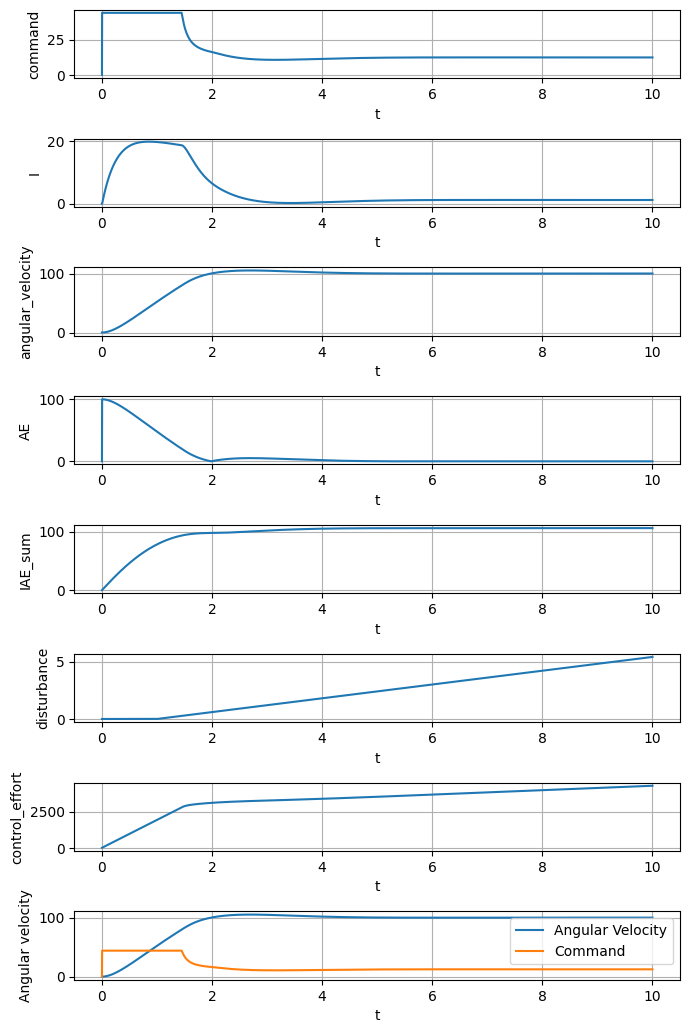

In [15]:
plots = len(res)
keys = list(res.keys())

plt.figure(figsize = (7, 10))

for i in range(1,plots):
    plt.subplot(plots,1,i)
    plt.plot(res['time'], res[keys[i]])
    plt.xlabel('t')
    plt.ylabel(keys[i])
    plt.grid()

plt.tight_layout()

plt.subplot(plots, 1,plots)
plt.plot(res['time'], res['angular_velocity'],label='Angular Velocity')
plt.plot(res['time'], res['command'],label='Command')
plt.xlabel('t')
plt.ylabel('Angular velocity')
plt.grid()
plt.legend()

plt.show()

In [ ]:
# Printing Percent overshot, Settling time, Steady state error
print(f" Percent overshoot is: {(max(res['angular_velocity']) - setpoint)/setpoint * 100}")
print(f" Settling time is: {t - settling_time}")
print(f" Steady state error: {res['angular_velocity'][-1] - setpoint}")


 Percent overshoot is: 5.175463672764295
 Settling time is: 3.6699999999994475
 Steady state error: 0.0013286256143345554
